# Problem

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.


The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.
 

The company wants to know:

1. Which variables are significant in predicting the price of a house, and

2. How well those variables describe the price of a house.

Also, determine the optimal value of lambda for ridge and lasso regression.

# Business Goal

We are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# setting display format so that large values are shown properly
pd.set_option('display.float_format', lambda x: '%.4f' % x)

sns.set_style(style='dark')
sns.set_context("notebook")

In [2]:
housing = pd.read_csv('train.csv')

In [3]:
housing.shape

(1460, 81)

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
housing.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL      65.0000     8450   Pave   NaN      Reg   
1   2          20       RL      80.0000     9600   Pave   NaN      Reg   
2   3          60       RL      68.0000    11250   Pave   NaN      IR1   
3   4          70       RL      60.0000     9550   Pave   NaN      IR1   
4   5          60       RL      84.0000    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [6]:
housing.index = housing['Id']

housing = housing.drop('Id',axis=1)

In [7]:
def get_columns_with_nan_percentage(df):
    nan_cols = [{
            "column":c,
            "percentage":round(100*(df[c].isnull().sum()/len(df[c].index)), 2),
            "type":df[c].dtype
            } for c in df.columns if round(100*(df[c].isnull().sum()/len(df[c].index)), 2)>0]
    return pd.DataFrame.from_records(nan_cols)

In [8]:
get_columns_with_nan_percentage(housing)

column  percentage     type
0    LotFrontage     17.7400  float64
1          Alley     93.7700   object
2     MasVnrType      0.5500   object
3     MasVnrArea      0.5500  float64
4       BsmtQual      2.5300   object
5       BsmtCond      2.5300   object
6   BsmtExposure      2.6000   object
7   BsmtFinType1      2.5300   object
8   BsmtFinType2      2.6000   object
9     Electrical      0.0700   object
10   FireplaceQu     47.2600   object
11    GarageType      5.5500   object
12   GarageYrBlt      5.5500  float64
13  GarageFinish      5.5500   object
14    GarageQual      5.5500   object
15    GarageCond      5.5500   object
16        PoolQC     99.5200   object
17         Fence     80.7500   object
18   MiscFeature     96.3000   object

#### We have so many column which have `NAN` but they are `NA` which are valid values.
Following columns have valid `NA`

1. Alley
2. MasVnrType
3. BsmtQual
4. BsmtCond
5. BsmtExposure
6. BsmtFinType1
7. BsmtFinType2
8. FireplaceQu
9. GarageType
10. GarageFinish
11. GarageQual
12. GarageCond
13. PoolQC
14. Fence
15. MiscFeature

In [9]:
def set_valid_na(columns, df):
    for column in columns:
        df[column].fillna('No_' + column, inplace=True)

In [10]:
set_valid_na([
    'Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
    'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
    'MiscFeature'
],housing)

In [11]:
get_columns_with_nan_percentage(housing)

column  percentage     type
0  LotFrontage     17.7400  float64
1   MasVnrArea      0.5500  float64
2   Electrical      0.0700   object
3  GarageYrBlt      5.5500  float64

Deleting rows where `MasVnrArea` and `Electrical` is `NAN`

In [12]:
housing = housing[~housing['MasVnrArea'].isnull()]
housing = housing[~housing['Electrical'].isnull()]

In [13]:
get_columns_with_nan_percentage(housing)

column  percentage     type
0  LotFrontage     17.7100  float64
1  GarageYrBlt      5.5800  float64

Let us analyze `LotFrontage`

In [14]:
housing['LotFrontage'].describe()

count   1194.0000
mean      70.0276
std       24.2993
min       21.0000
25%       59.0000
50%       69.0000
75%       80.0000
max      313.0000
Name: LotFrontage, dtype: float64

Updating `LotFrontage` with mean of the data

In [15]:
housing['LotFrontage'].fillna((housing['LotFrontage'].mean()), inplace=True)

In [16]:
get_columns_with_nan_percentage(housing)

column  percentage     type
0  GarageYrBlt      5.5800  float64

Updating `GarageYrBlt` with median year for the area.

In [17]:
housing['GarageYrBlt'].fillna((housing['GarageYrBlt'].median()), inplace=True)

In [18]:
get_columns_with_nan_percentage(housing)

Empty DataFrame
Columns: []
Index: []

Now, we can see that there is no NAN in the dataset

There are some columns which are numeric but according to the data dictionary they are categorical. We can convert these columns as categorical.

In [19]:
housing.select_dtypes(include=['float64','int64']).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Following columns can be converted to categorical.

1. MSSubClass
2. OverallQual
3. OverallCond
4. BsmtFullBath
5. BsmtHalfBath
6. FullBath
7. HalfBath
8. BedroomAbvGr
9. KitchenAbvGr
10. TotRmsAbvGrd
11. Fireplaces
12. GarageCars
13. MoSold
14. YrSold
15. GarageYrBlt
16. YearBuilt
17. YearRemodAdd

In [20]:
def convert_to_category(columns):
    for column in columns:
        housing[column] = housing[column].astype('object')

In [21]:
convert_to_category([
    'MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath',
    'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
    'Fireplaces', 'GarageCars', 'MoSold', 'YrSold', 'GarageYrBlt', 'YearBuilt',
    'YearRemodAdd'
])

In [22]:
def get_int_float_columns_with_Zero_percentage(df):
    nan_cols = [{
            "column":c,
            "percentage":round(100*((df[c]==0).sum()/len(df[c].index)), 2),
            "type":df[c].dtype
            } for c in df.columns if round(100*((df[c]==0).sum().sum()/len(df[c].index)), 2)>0]
    return pd.DataFrame.from_records(nan_cols)

In [23]:
get_int_float_columns_with_Zero_percentage(housing.select_dtypes(include=['float64','int64']))

column  percentage     type
0      MasVnrArea     59.2700  float64
1      BsmtFinSF1     31.9800    int64
2      BsmtFinSF2     88.4900    int64
3       BsmtUnfSF      8.1300    int64
4     TotalBsmtSF      2.5500    int64
5        2ndFlrSF     56.7900    int64
6    LowQualFinSF     98.2100    int64
7      GarageArea      5.5800    int64
8      WoodDeckSF     52.0300    int64
9     OpenPorchSF     45.0000    int64
10  EnclosedPorch     85.7300    int64
11      3SsnPorch     98.3500    int64
12    ScreenPorch     92.0100    int64
13       PoolArea     99.5200    int64
14        MiscVal     96.4200    int64

We can delete the columns which have more 80% **0** values as shown above.

In [24]:
housing = housing.drop([
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
    'PoolArea', 'MiscVal'
],
                       axis=1)

## Analysis of the data

Reference for the following methods: https://towardsdatascience.com/a-starter-pack-to-exploratory-data-analysis-with-python-pandas-seaborn-and-scikit-learn-a77889485baf#89dd and the previous assignments.

In [25]:
default_figsize = (15, 5)
default_xtick_angle = 50

In [26]:
def categorical_summarized(dataframe,
                           x=None,
                           y=None,
                           hue=None,
                           palette='Set1',
                           verbose=True,
                           figsize=default_figsize,
                           title="",
                           xlabel=None,
                           ylabel=None,
                           rotate_labels=False):
    '''
    Helper function that gives a quick summary of a given column of categorical data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data, y would be the count
    y: str. vertical axis to plot the labels of categorical data, x would be the count
    hue: str. if you want to compare it another variable (usually the target variable)
    palette: array-like. Colour of the plot
    Returns
    =======
    Quick Stats of the data and also the count plot
    '''
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]

    if verbose:
        print(series.describe())
        print('mode: ', series.mode())
        print('=' * 80)
        print(series.value_counts())

    sns.set(rc={'figure.figsize': figsize})
    sorted_df = dataframe.sort_values(column_interested)
    ax = sns.countplot(x=x, y=y, hue=hue, data=sorted_df)

    plt.title(title)
    if not xlabel:
        xlabel = column_interested
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    total = len(dataframe[column_interested])
    if rotate_labels:
        plt.setp(ax.get_xticklabels(),
                 rotation=30,
                 horizontalalignment='right')
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height() / 2
        ax.annotate(percentage, (x, y))
    plt.tight_layout()
    plt.style.use('fivethirtyeight')
    plt.xticks(rotation=default_xtick_angle)
    plt.show()

In [27]:
def quantitative_summarized(dataframe,
                            x=None,
                            y=None,
                            hue=None,
                            palette='Set1',
                            ax=None,
                            verbose=True,
                            swarm=False,
                            figsize=default_figsize):
    '''
    Helper function that gives a quick summary of quantattive data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlayed
    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    '''
    series = dataframe[y]
    print(series.describe())
    if verbose:
        print('mode: ', series.mode())
        print('=' * 80)
        print(series.value_counts())
    sns.set(rc={'figure.figsize': figsize})

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe, palette=palette, ax=ax)

    if swarm:
        sns.swarmplot(x=x,
                      y=y,
                      hue=hue,
                      data=dataframe,
                      palette=palette,
                      ax=ax)
    plt.tight_layout()
    plt.style.use('fivethirtyeight')
    plt.xticks(rotation=default_xtick_angle)
    plt.show()

In [28]:
def plot_column(df,
                col,
                chart_type='Hist',
                dtype=int,
                bins=25,
                figsize=default_figsize):
    temp_df = df[col]
    sns.set(rc={'figure.figsize': figsize})
    if chart_type == 'Hist':
        ax = sns.countplot(temp_df)
    elif chart_type == 'Dens':
        ax = sns.distplot(temp_df)
    xmin, xmax = ax.get_xlim()
    ax.set_xticks(np.round(np.linspace(xmin, xmax, bins), 2))
    plt.tight_layout()
    plt.locator_params(axis='y', nbins=6)
    plt.xticks(rotation=default_xtick_angle)
    plt.style.use('fivethirtyeight')
    plt.show()

In [29]:
def univariate_analysis(col,
                        chart_type='Dens',
                        df=housing,
                        is_categorical=False,
                        title="",
                        xlabel=None,
                        ylabel=None,
                        rotate_labels=False,
                        bins=25):
    if is_categorical:
        categorical_summarized(df,
                               x=col,
                               title=title,
                               xlabel=xlabel,
                               ylabel=ylabel,
                               rotate_labels=rotate_labels,
                               verbose=False)
    else:
        quantitative_summarized(df, y=col, verbose=False)
        plot_column(df, col, chart_type=chart_type, bins=bins)


### *SalePrice* is the dependent variable, so let us start with the analysis of SalePrice


count     1451.0000
mean    180624.1020
std      79312.1283
min      34900.0000
25%     129900.0000
50%     162500.0000
75%     214000.0000
max     755000.0000
Name: SalePrice, dtype: float64


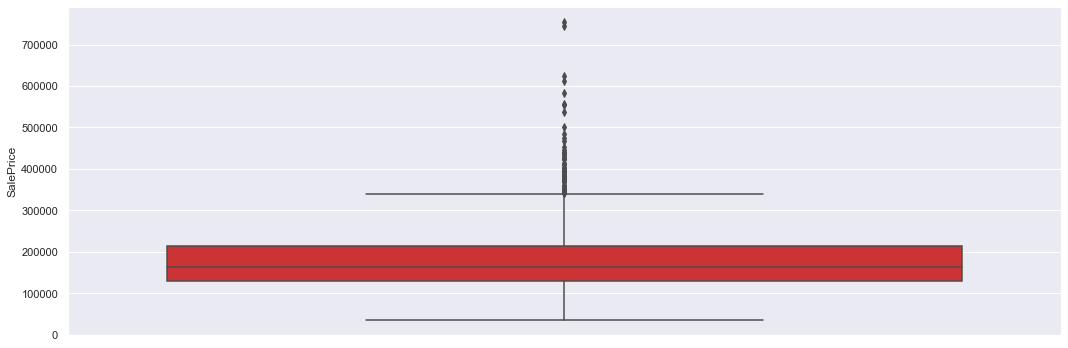

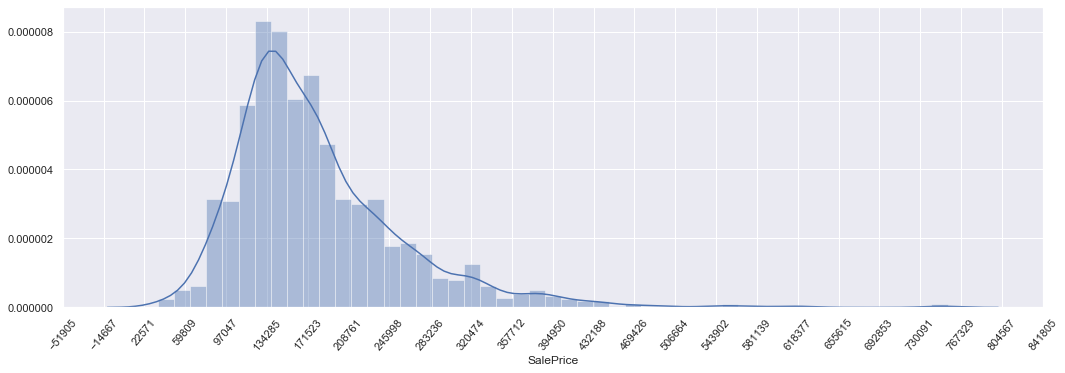

In [30]:
univariate_analysis('SalePrice')

As we can see that the price is skewed and is not normally distributed. We can use log transform and see the behavior.

In [31]:
housing['NormalSalePrice'] = np.log(housing["SalePrice"])

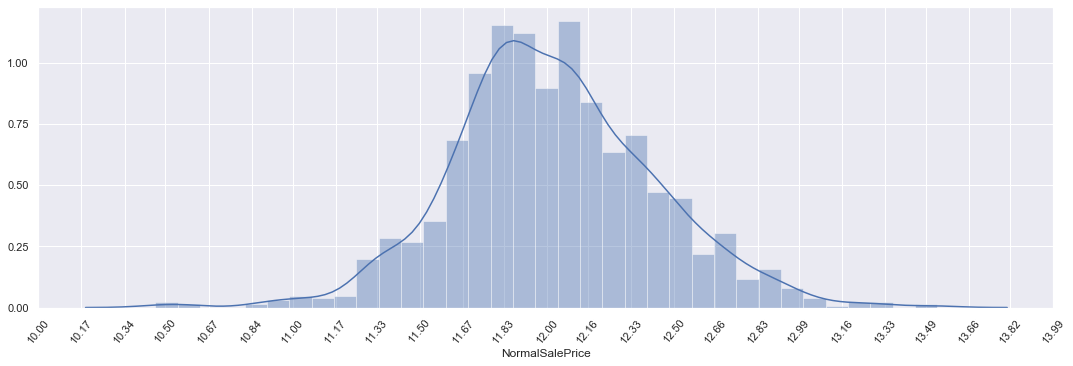

In [32]:
plot_column(housing, 'NormalSalePrice', chart_type='Dens', bins=25)

#### As we can see that, the log transformed price is normally distributed, thus we will use this column moving forward for the model creation.

In [33]:
# Dropping `SalePrice` column
housing = housing.drop('SalePrice', axis=1)

Now, we will try to find all the columns which have almost similar values. Here, I am considering columns which have 90% same value.

In [34]:
x=.90
columns_to_delete=[]
for c in housing.columns:
    if(any(y > x for y in housing[c].value_counts(dropna=False, normalize=True).tolist())):
        columns_to_delete.append(c)
columns_to_delete

['Street',
 'Alley',
 'Utilities',
 'LandSlope',
 'Condition2',
 'RoofMatl',
 'Heating',
 'CentralAir',
 'Electrical',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'Functional',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'MiscFeature']

We can delete the above columns as they are skewed.

In [35]:
housing = housing.drop(columns_to_delete, axis=1)

In [36]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 1 to 1460
Data columns (total 57 columns):
MSSubClass         1451 non-null object
MSZoning           1451 non-null object
LotFrontage        1451 non-null float64
LotArea            1451 non-null int64
LotShape           1451 non-null object
LandContour        1451 non-null object
LotConfig          1451 non-null object
Neighborhood       1451 non-null object
Condition1         1451 non-null object
BldgType           1451 non-null object
HouseStyle         1451 non-null object
OverallQual        1451 non-null object
OverallCond        1451 non-null object
YearBuilt          1451 non-null object
YearRemodAdd       1451 non-null object
RoofStyle          1451 non-null object
Exterior1st        1451 non-null object
Exterior2nd        1451 non-null object
MasVnrType         1451 non-null object
MasVnrArea         1451 non-null float64
ExterQual          1451 non-null object
ExterCond          1451 non-null object
Foundation  

### Defining variables

## Categorical Variables

    'MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageQual', 'Fence', 'SaleType',
       'SaleCondition', 'MoSold', 'YrSold', 'YearRemodAdd', 'GarageYrBlt'

## Continuous Variables

    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'NormalSalePrice', 'Age'

# Analyzing categorical variables 

In [37]:
def bivariate_analysis(col, df=housing, is_categorical=True):
    univariate_analysis(col, is_categorical=is_categorical)
    quantitative_summarized(dataframe=housing,
                            y='NormalSalePrice',
                            x=col,
                            swarm=True,
                            verbose=False)

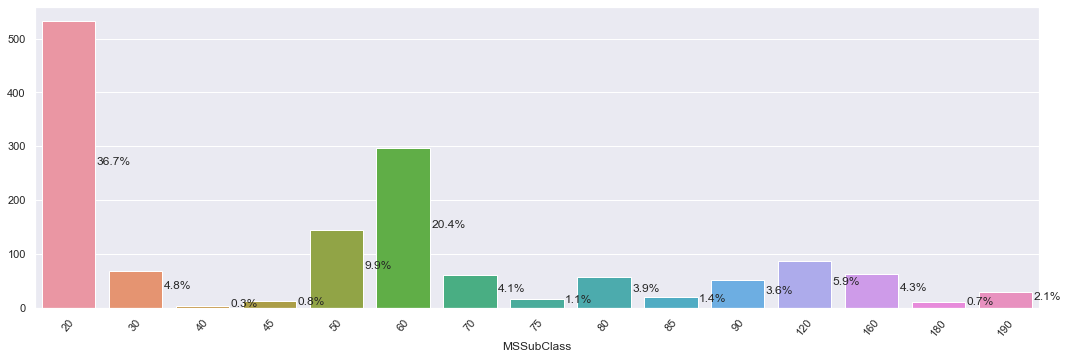

count   1451.0000
mean      12.0224
std        0.3995
min       10.4602
25%       11.7745
50%       11.9984
75%       12.2737
max       13.5345
Name: NormalSalePrice, dtype: float64


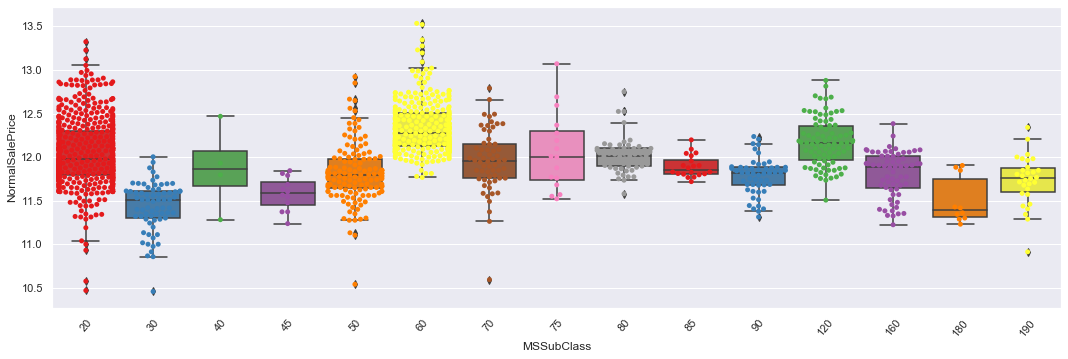

In [38]:
bivariate_analysis('MSSubClass')

We can see that most of the properties belong to MSSubClass 20. However, properties belonging to class 60 are in general more costly.

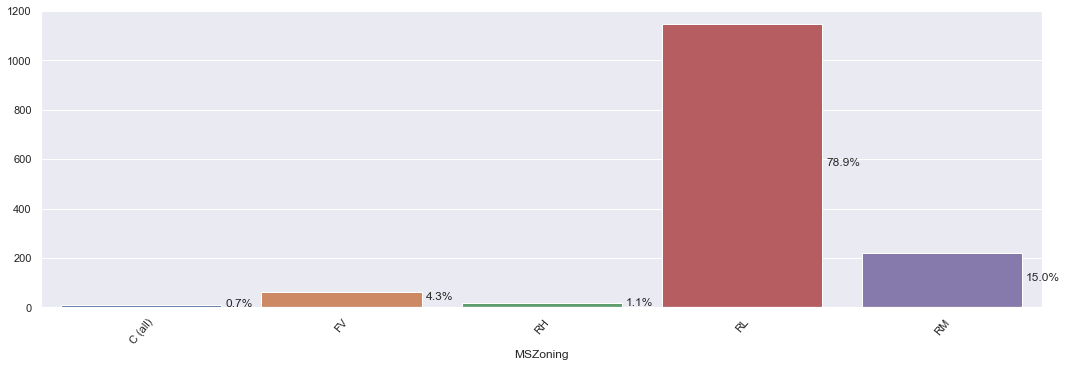

count   1451.0000
mean      12.0224
std        0.3995
min       10.4602
25%       11.7745
50%       11.9984
75%       12.2737
max       13.5345
Name: NormalSalePrice, dtype: float64


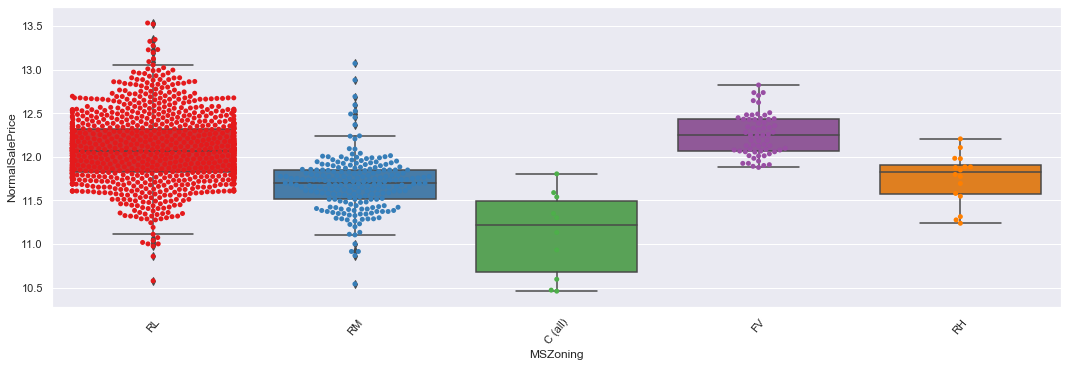

In [39]:
bivariate_analysis('MSZoning')

We can see most of the properties belong to `RL` MSZone with wide range of pricing.

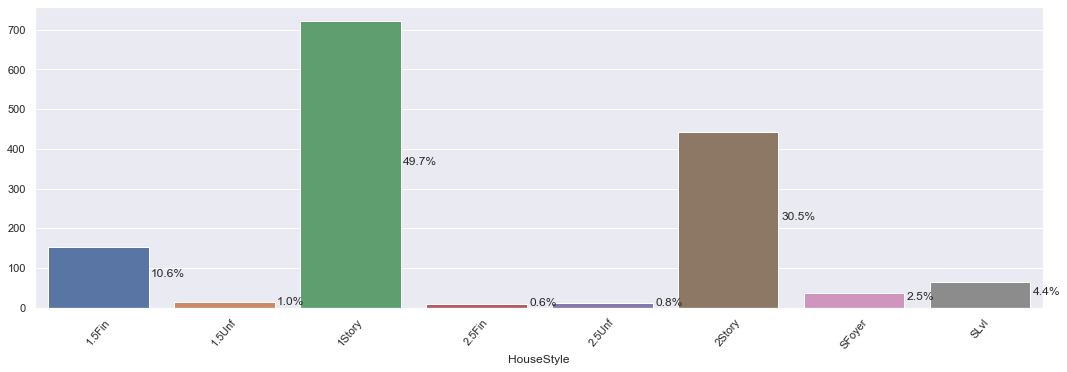

count   1451.0000
mean      12.0224
std        0.3995
min       10.4602
25%       11.7745
50%       11.9984
75%       12.2737
max       13.5345
Name: NormalSalePrice, dtype: float64


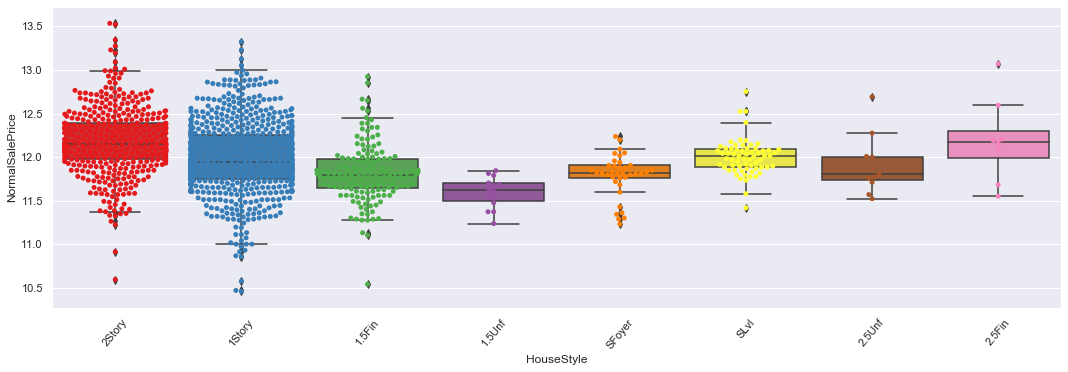

In [40]:
bivariate_analysis('HouseStyle')

1Story properties are the most sold ones and also has range in the price.

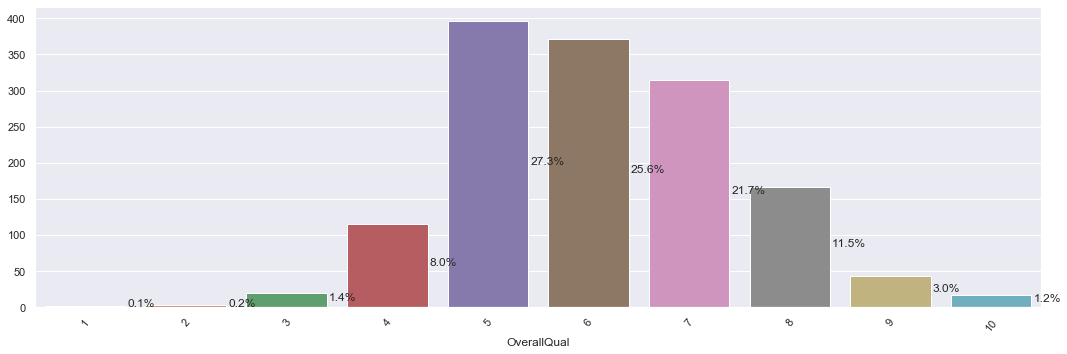

count   1451.0000
mean      12.0224
std        0.3995
min       10.4602
25%       11.7745
50%       11.9984
75%       12.2737
max       13.5345
Name: NormalSalePrice, dtype: float64


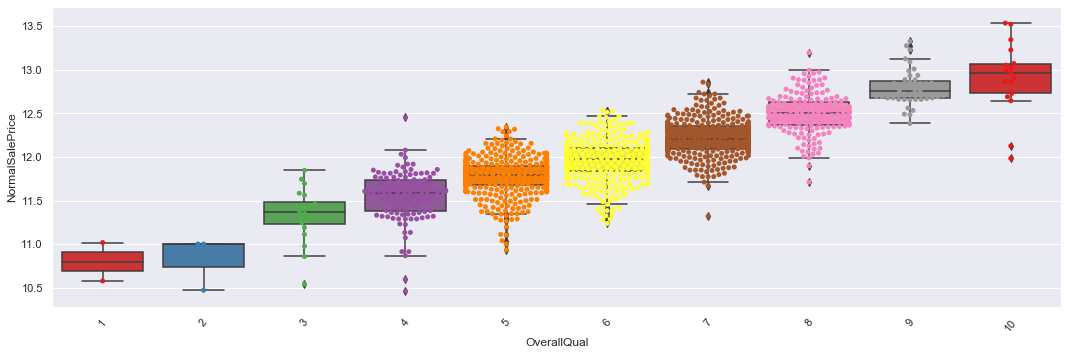

In [41]:
bivariate_analysis('OverallQual')

The most sold properties belong to **5** and **6**. We can see as the over all quality increases the price also increases.

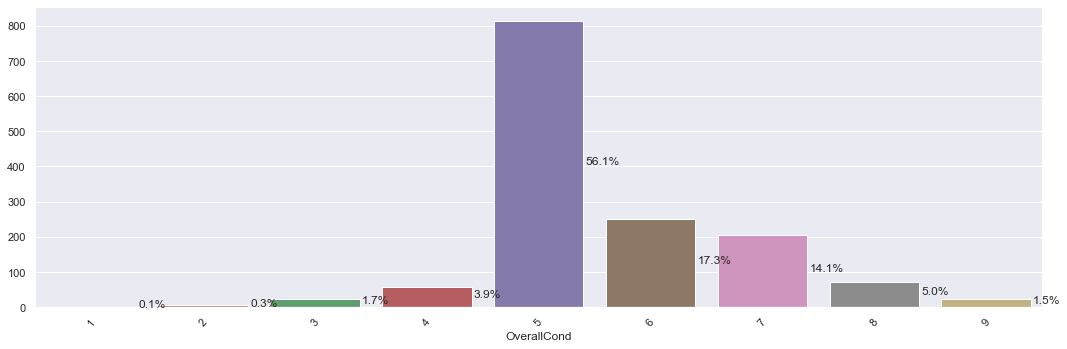

count   1451.0000
mean      12.0224
std        0.3995
min       10.4602
25%       11.7745
50%       11.9984
75%       12.2737
max       13.5345
Name: NormalSalePrice, dtype: float64


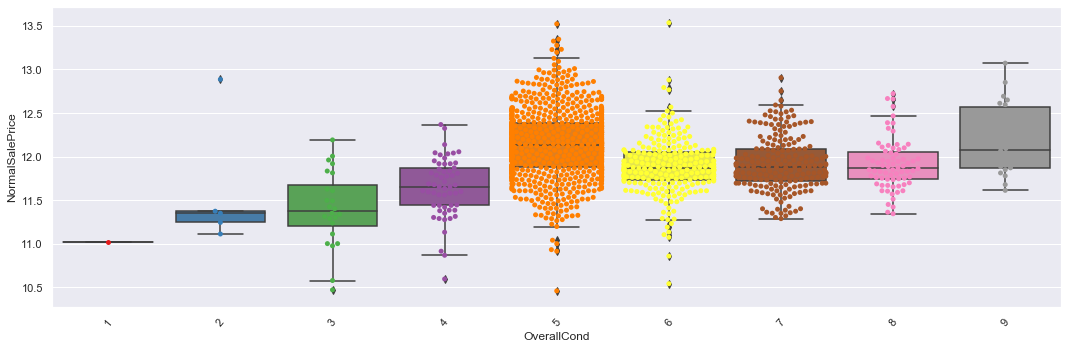

In [42]:
bivariate_analysis('OverallCond')

The most sold properties belong to 5 and 6 and as the overall condition increases the price is also increasing.

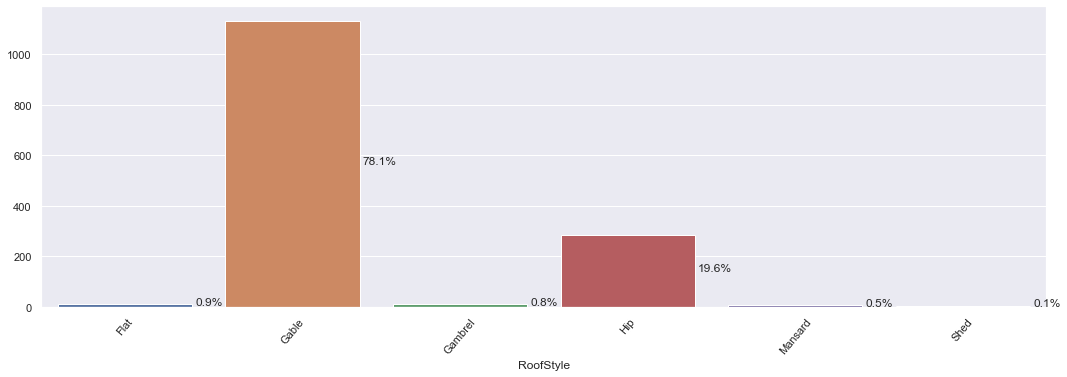

count   1451.0000
mean      12.0224
std        0.3995
min       10.4602
25%       11.7745
50%       11.9984
75%       12.2737
max       13.5345
Name: NormalSalePrice, dtype: float64


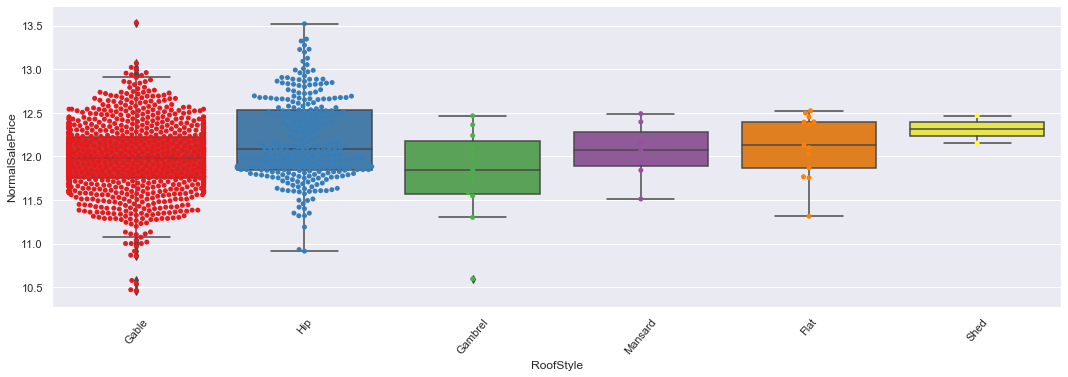

In [43]:
bivariate_analysis('RoofStyle')

Gable roof type properties are the most sold ones. However, **shed** type properties have less variation is price.

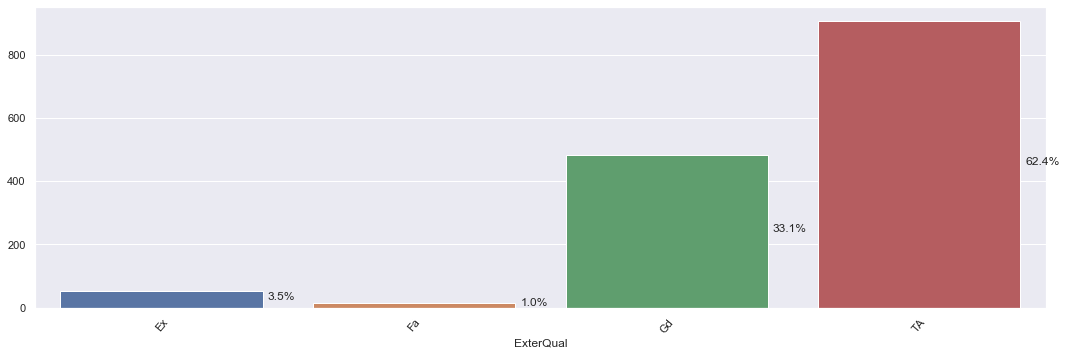

count   1451.0000
mean      12.0224
std        0.3995
min       10.4602
25%       11.7745
50%       11.9984
75%       12.2737
max       13.5345
Name: NormalSalePrice, dtype: float64


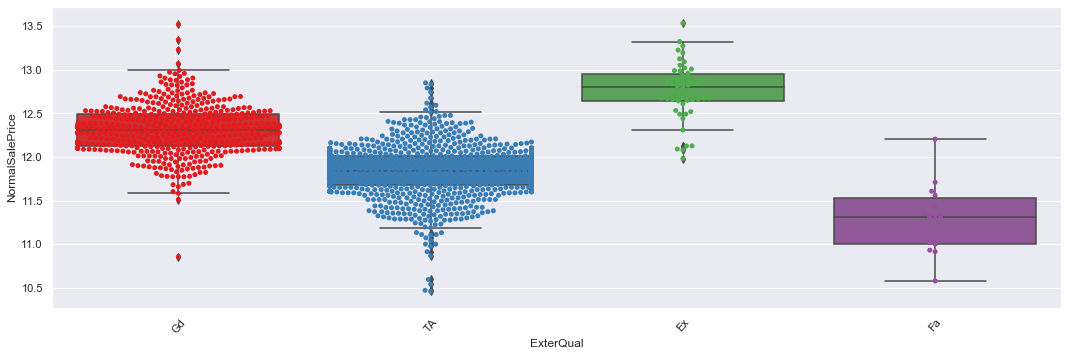

In [44]:
bivariate_analysis('ExterQual')

Most of the sold properties belong to TA

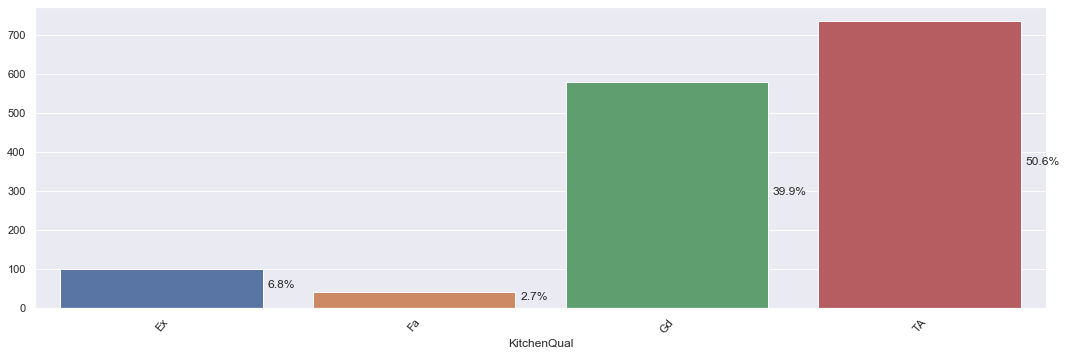

count   1451.0000
mean      12.0224
std        0.3995
min       10.4602
25%       11.7745
50%       11.9984
75%       12.2737
max       13.5345
Name: NormalSalePrice, dtype: float64


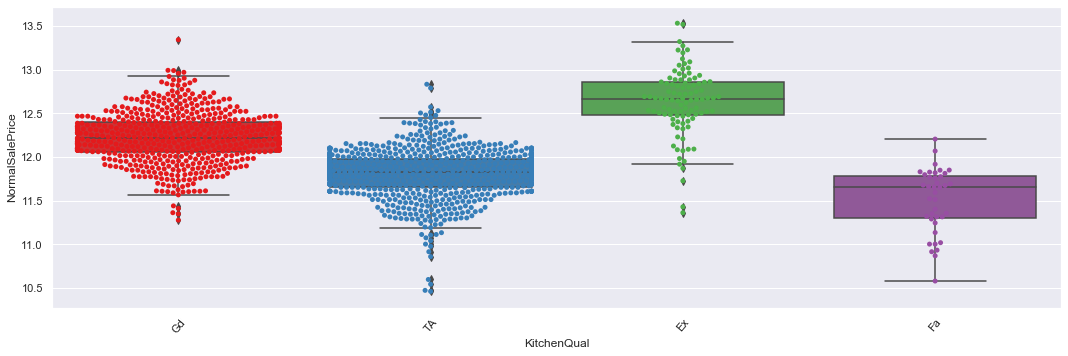

In [45]:
bivariate_analysis('KitchenQual')

Most of the properties have average kitchen type.

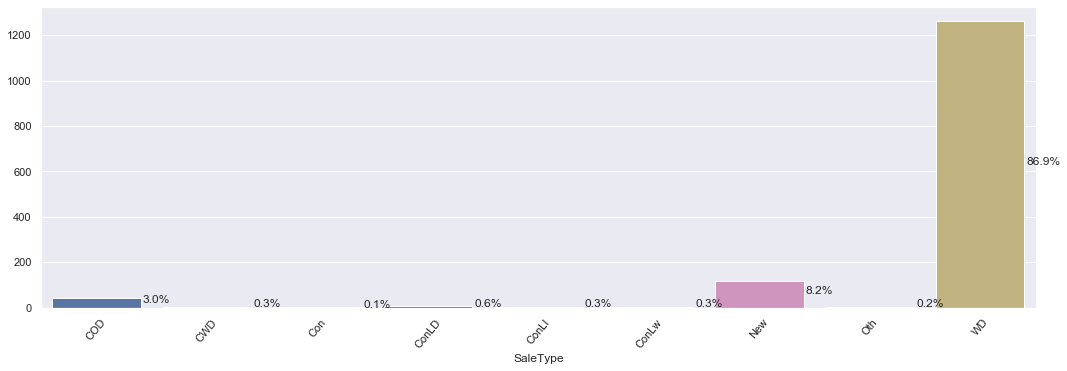

count   1451.0000
mean      12.0224
std        0.3995
min       10.4602
25%       11.7745
50%       11.9984
75%       12.2737
max       13.5345
Name: NormalSalePrice, dtype: float64


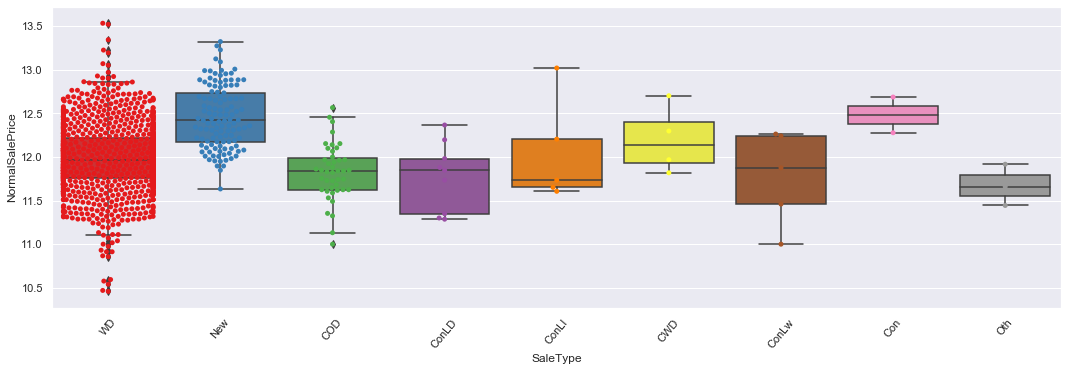

In [46]:
bivariate_analysis('SaleType')

Most of the sales are warrantee deeds and they vary in price too.

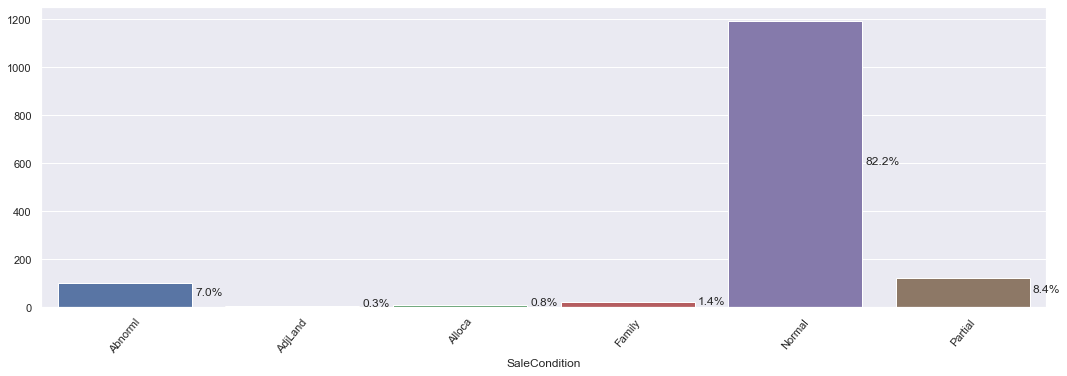

count   1451.0000
mean      12.0224
std        0.3995
min       10.4602
25%       11.7745
50%       11.9984
75%       12.2737
max       13.5345
Name: NormalSalePrice, dtype: float64


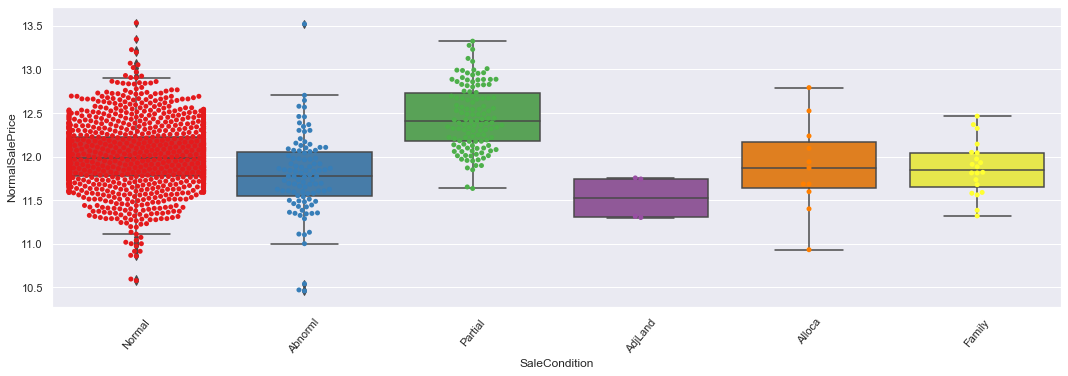

In [47]:
bivariate_analysis('SaleCondition')

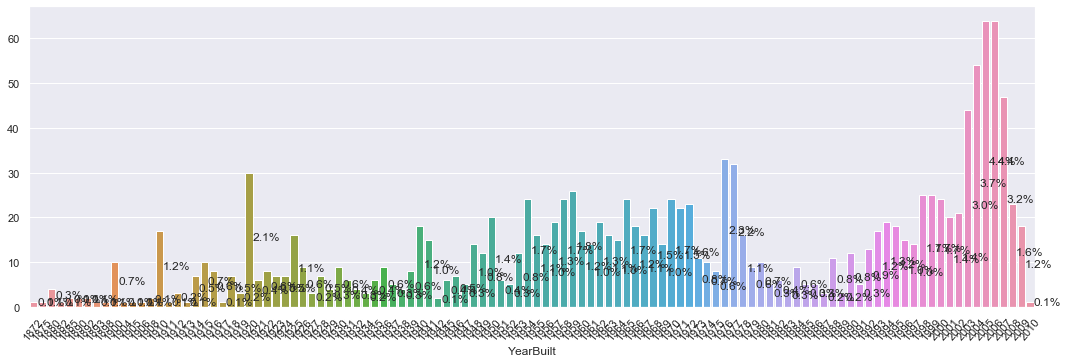

count   1451.0000
mean      12.0224
std        0.3995
min       10.4602
25%       11.7745
50%       11.9984
75%       12.2737
max       13.5345
Name: NormalSalePrice, dtype: float64


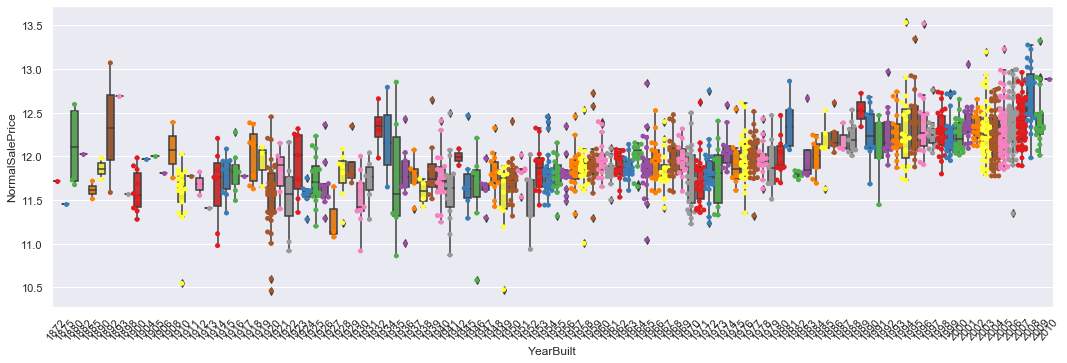

In [48]:
bivariate_analysis('YearBuilt', is_categorical=True)

#### `MoSold`, `YrSold`, `YearRemodAdd` and `GarageYrBlt` will not have impact on the sale price of the property. We will consider `YearBuilt` to calculate the age of the property.

We can see that most property which are sold are built after 2003, we can create a new column `Age` for the properties.

### Adding new column age for the property

In [49]:
# Dropping MoSold, YrSold, YearRemodAdd and GarageYrBlt

housing = housing.drop(['MoSold', 'YrSold', 'YearRemodAdd', 'GarageYrBlt'],
                       axis=1)

housing['Age'] = housing['YearBuilt'].apply(lambda x: 2020 - x).astype(int)
housing = housing.drop('YearBuilt', axis=1)

## Analyzing continuous variables

In [50]:
housing_num = housing.select_dtypes(include=['float64','int64'])
num_vars = housing_num.columns

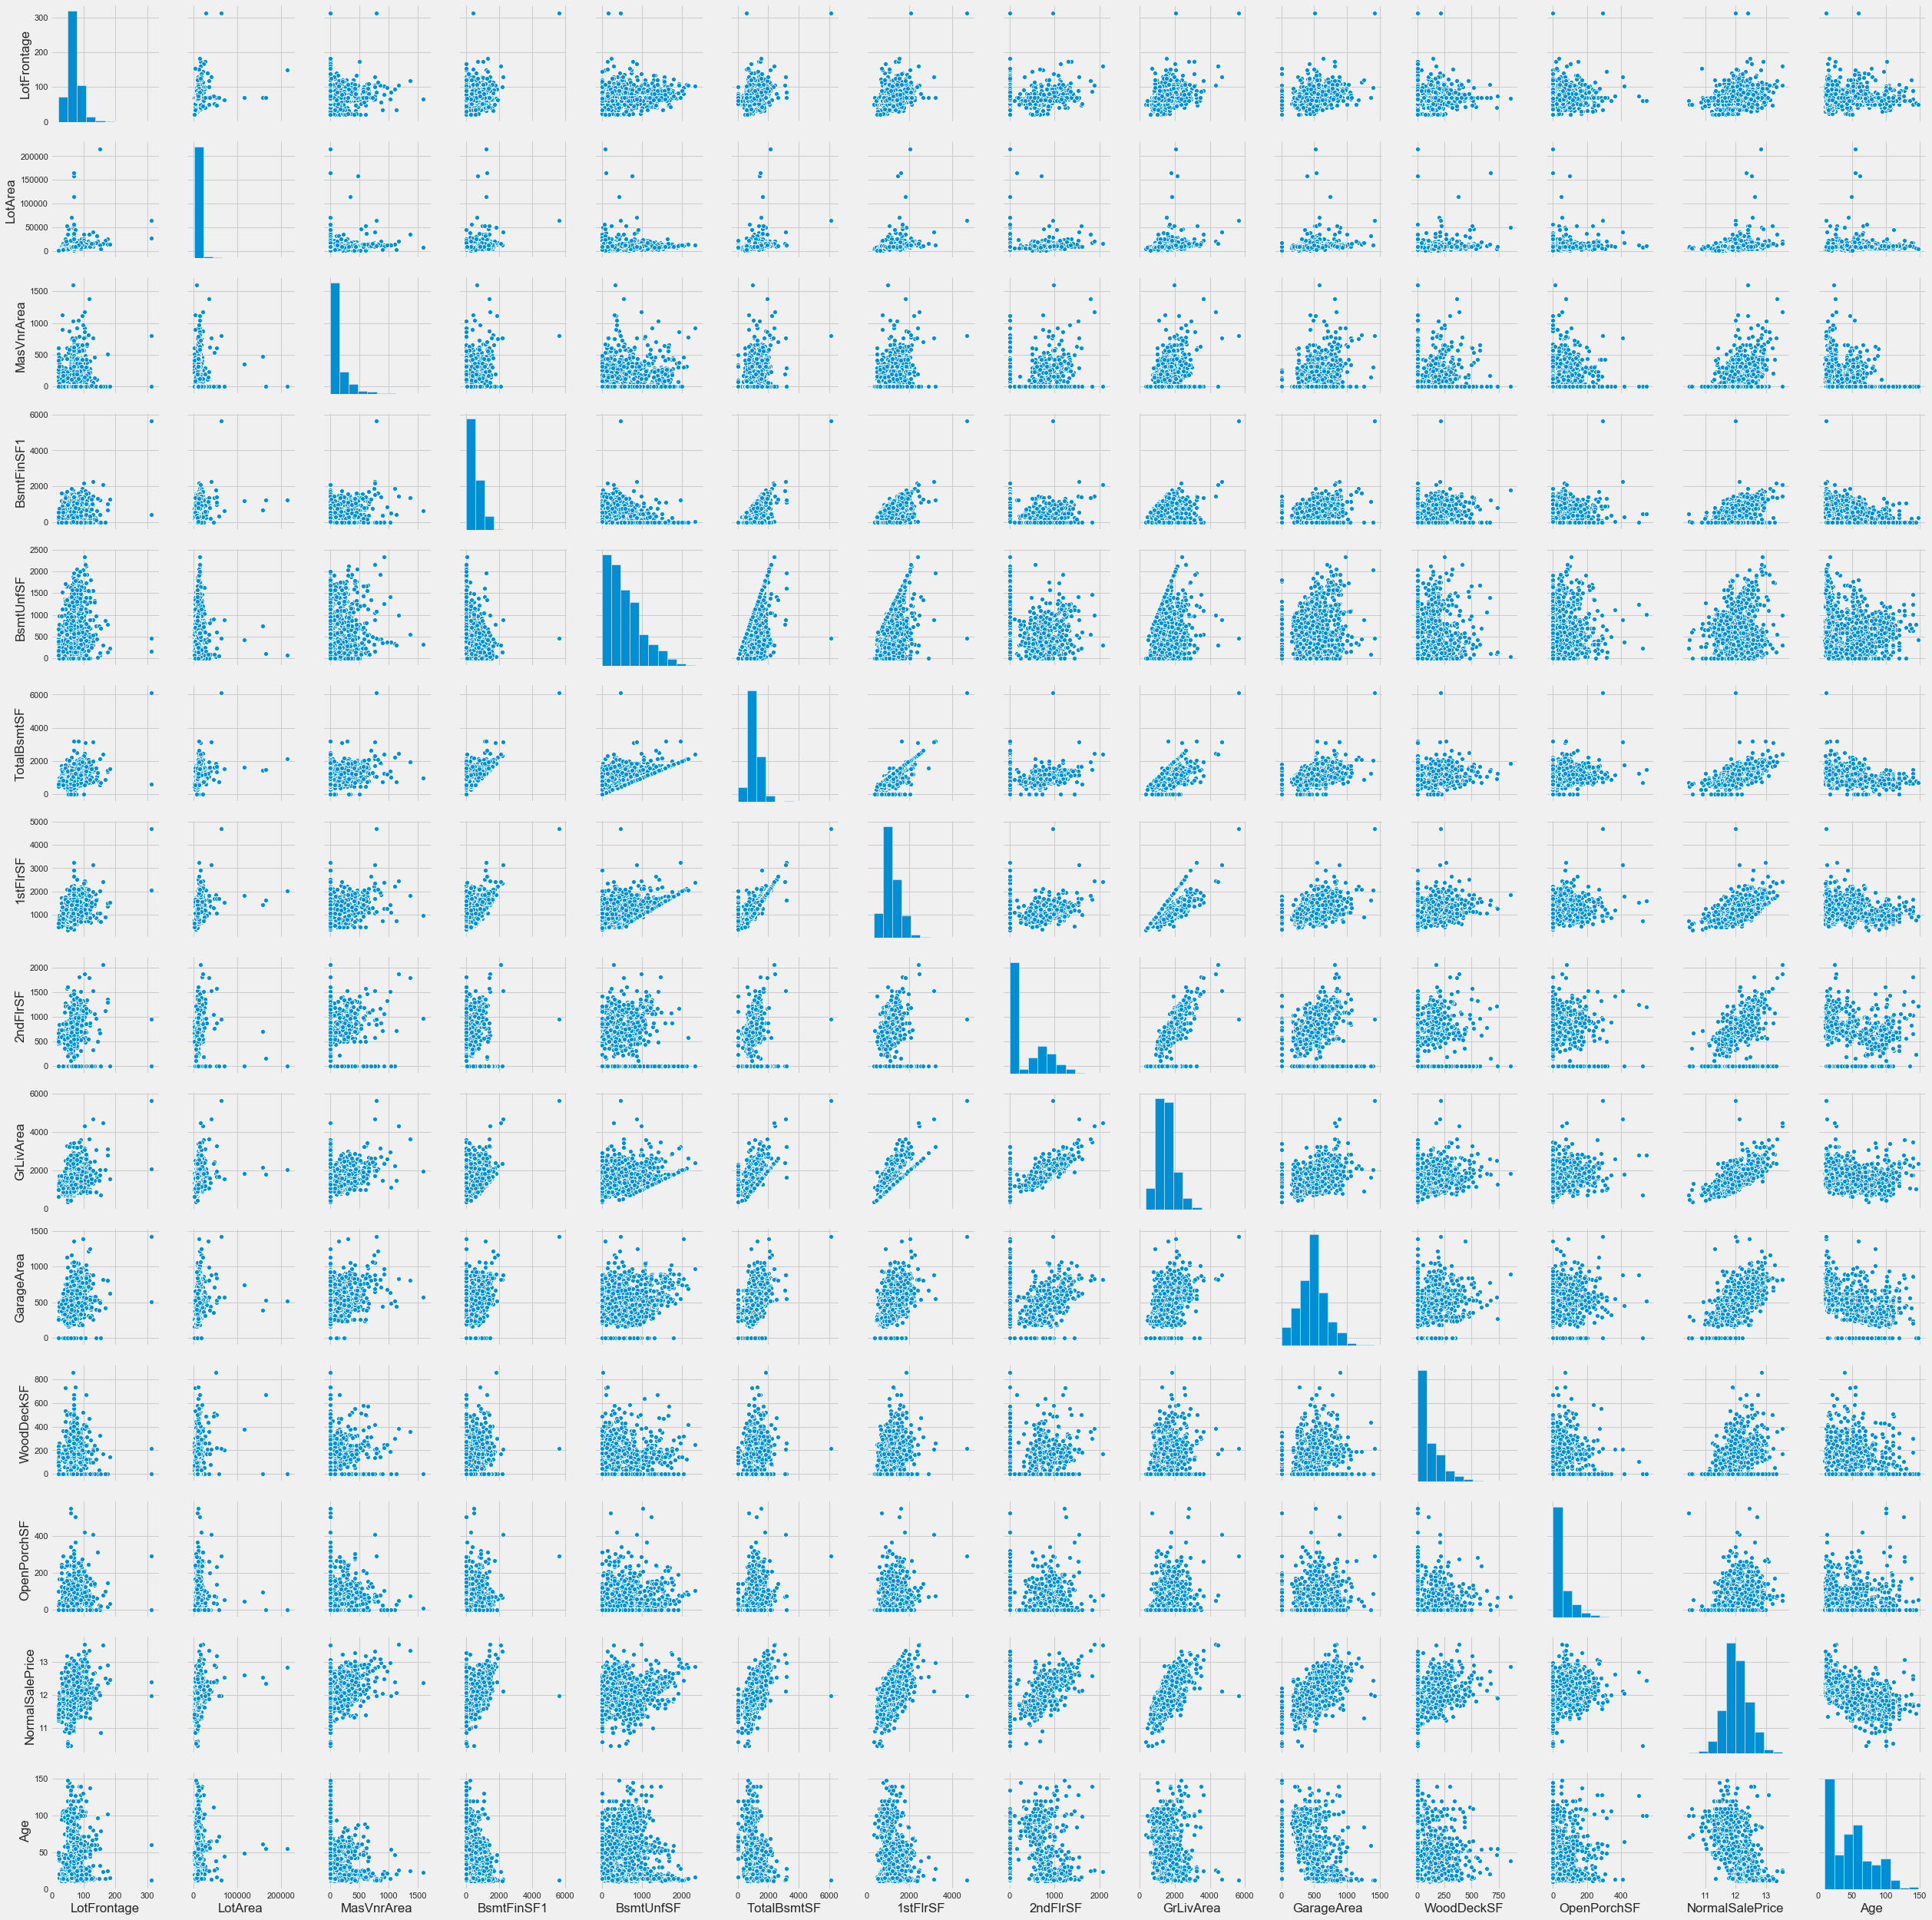

In [51]:
sns.pairplot(housing_num)

We can see outliers in some of the charts against NormalSalesPrice. We will use IQR to identify and remove outliers

## Removing outliers

In [52]:
def get_lower_upper_bound(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)

    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 2.5)
    return lower_bound, upper_bound

In [53]:
outlier_columns = [
    'LotFrontage', 'LotArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF',
    '2ndFlrSF'
]
for column in outlier_columns:
    lower, upper = get_lower_upper_bound(housing[column])
    housing = housing[housing[column] < upper]    

In [54]:
def heat_map(data):
    corr = data.corr()
    sns.set(rc={'figure.figsize': (15, 10)})
    plt.tight_layout()
    ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu',annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

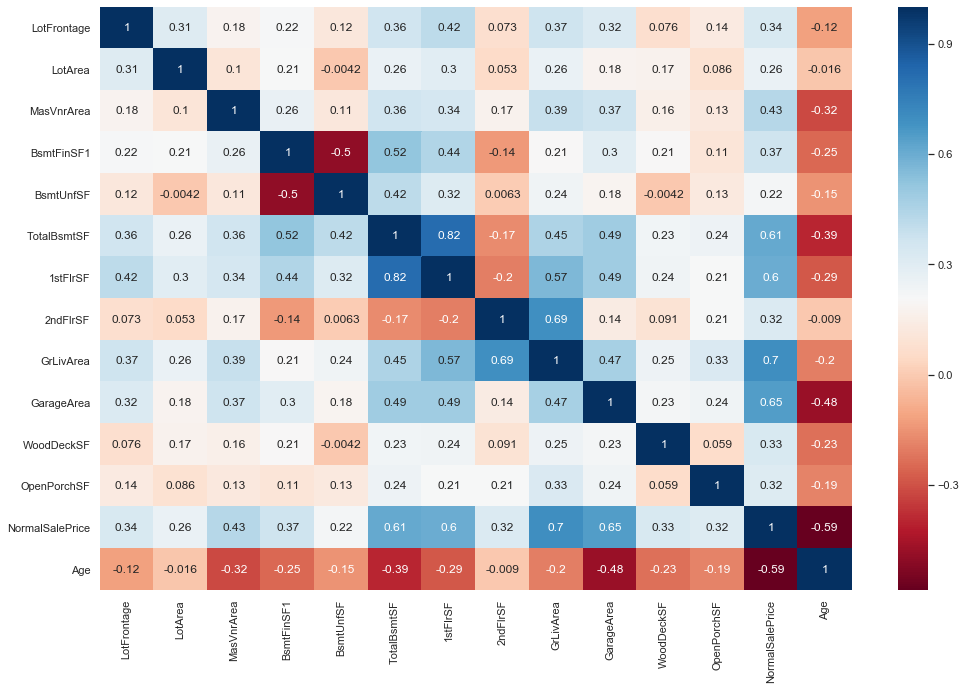

In [55]:
heat_map(housing_num)

We can see that following variables have correlation with `NormalSalePrice`
1. GarageArea
2. GrLivArea
3. TotalBsmtSF
4. 1stFlrSF
5. Age
6. MaxVnrArea

# Data preparation

We will introduce dummy variables followed by scaling the numerical variables

## Dummy Variable

In [56]:
columns_to_encode = housing.select_dtypes(include=['category', 'object'])
housing_model = housing
for c in columns_to_encode:
    housing_model = pd.get_dummies(housing_model,
                                   prefix=[c],
                                   columns=[c],
                                   drop_first=True)

In [57]:
housing_model.shape

(1382, 251)

## Splitting the Data into Training and Testing Sets

In [58]:
from sklearn.model_selection import train_test_split

np.random.seed(0)
housing_model_train, housing_model_test = train_test_split(housing_model,
                                                            train_size=0.7,
                                                            test_size=0.3,
                                                            random_state=100)

### Rescaling the Features

In [59]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

housing_model_train[num_vars] = scaler.fit_transform(
    housing_model_train[num_vars])

In [60]:

housing_model_train.head()

LotFrontage  LotArea  MasVnrArea  BsmtFinSF1  BsmtUnfSF  TotalBsmtSF  \
Id                                                                           
840        0.4757   0.5313      0.0000      0.2075     0.1781       0.3211   
1072       0.5534   0.5279      0.0000      0.1757     0.1836       0.3039   
279        0.8350   0.6675      0.3055      0.0000     0.9080       0.8867   
191        0.4757   0.4706      0.0000      0.1751     0.2380       0.3566   
107        0.3786   0.4822      0.0000      0.0000     0.2744       0.2680   

      1stFlrSF  2ndFlrSF  GrLivArea  GarageArea  ...  SaleType_ConLI  \
Id                                               ...                   
840     0.2109    0.2376     0.2741      0.1923  ...               0   
1072    0.2405    0.3999     0.3868      0.3534  ...               0   
279     0.8683    0.0000     0.5657      0.5865  ...               0   
191     0.5904    0.6480     0.7575      0.3526  ...               0   
107     0.3465    0.0000     0.2257      0.2188  ...               0   

      SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
Id                                                              
840                0             0             0            1   
1072               0             0             0            1   
279                0             1             0            0   
191                0             0             0            1   
107                0             0             0            1   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
Id                                                                        
840                       0                     0                     0   
1072                      0                     0                     0   
279                       0                     0                     0   
191                       0                     0                     0   
107                       0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
Id                                                 
840                      1                      0  
1072                     1                      0  
279                      0                      1  
191                      1                      0  
107                      1                      0  

[5 rows x 251 columns]

### Dividing into X and Y sets for the model building

In [61]:
y_train = housing_model_train.pop('NormalSalePrice')
X_train = housing_model_train

### Scalling Test data

In [62]:
housing_model_test[num_vars] = scaler.transform(housing_model_test[num_vars])

# Model Building and Evaluation

## Ridge Regression

In [63]:
params = {
    'alpha': [
        0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
        1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500,
        1000
    ]
}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator=ridge,
                        param_grid=params,
                        scoring='neg_mean_absolute_error',
                        cv=folds,
                        return_train_score=True,
                        verbose=1)
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [64]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha'] <= 200]
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0         0.0051        0.0035           0.0009          0.0001      0.0001   
1         0.0032        0.0004           0.0009          0.0001      0.0010   
2         0.0037        0.0007           0.0011          0.0002      0.0100   
3         0.0029        0.0001           0.0008          0.0000      0.0500   
4         0.0029        0.0001           0.0008          0.0000      0.1000   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}            -0.0344            -0.0320            -0.0344   
1   {'alpha': 0.001}            -0.0343            -0.0320            -0.0344   
2    {'alpha': 0.01}            -0.0340            -0.0317            -0.0343   
3    {'alpha': 0.05}            -0.0334            -0.0311            -0.0338   
4     {'alpha': 0.1}            -0.0330            -0.0306            -0.0333   

   split3_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
0            -0.0332  ...          -0.0330          0.0014               24   
1            -0.0332  ...          -0.0330          0.0014               23   
2            -0.0327  ...          -0.0327          0.0013               22   
3            -0.0313  ...          -0.0320          0.0014               20   
4            -0.0303  ...          -0.0315          0.0014               19   

   split0_train_score  split1_train_score  split2_train_score  \
0             -0.0200             -0.0205             -0.0196   
1             -0.0200             -0.0205             -0.0196   
2             -0.0200             -0.0205             -0.0196   
3             -0.0200             -0.0206             -0.0197   
4             -0.0201             -0.0207             -0.0198   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
0             -0.0200             -0.0205           -0.0201           0.0004  
1             -0.0200             -0.0205           -0.0201           0.0004  
2             -0.0200             -0.0205           -0.0201           0.0004  
3             -0.0202             -0.0206           -0.0202           0.0004  
4             -0.0203             -0.0206           -0.0203           0.0004  

[5 rows x 21 columns]

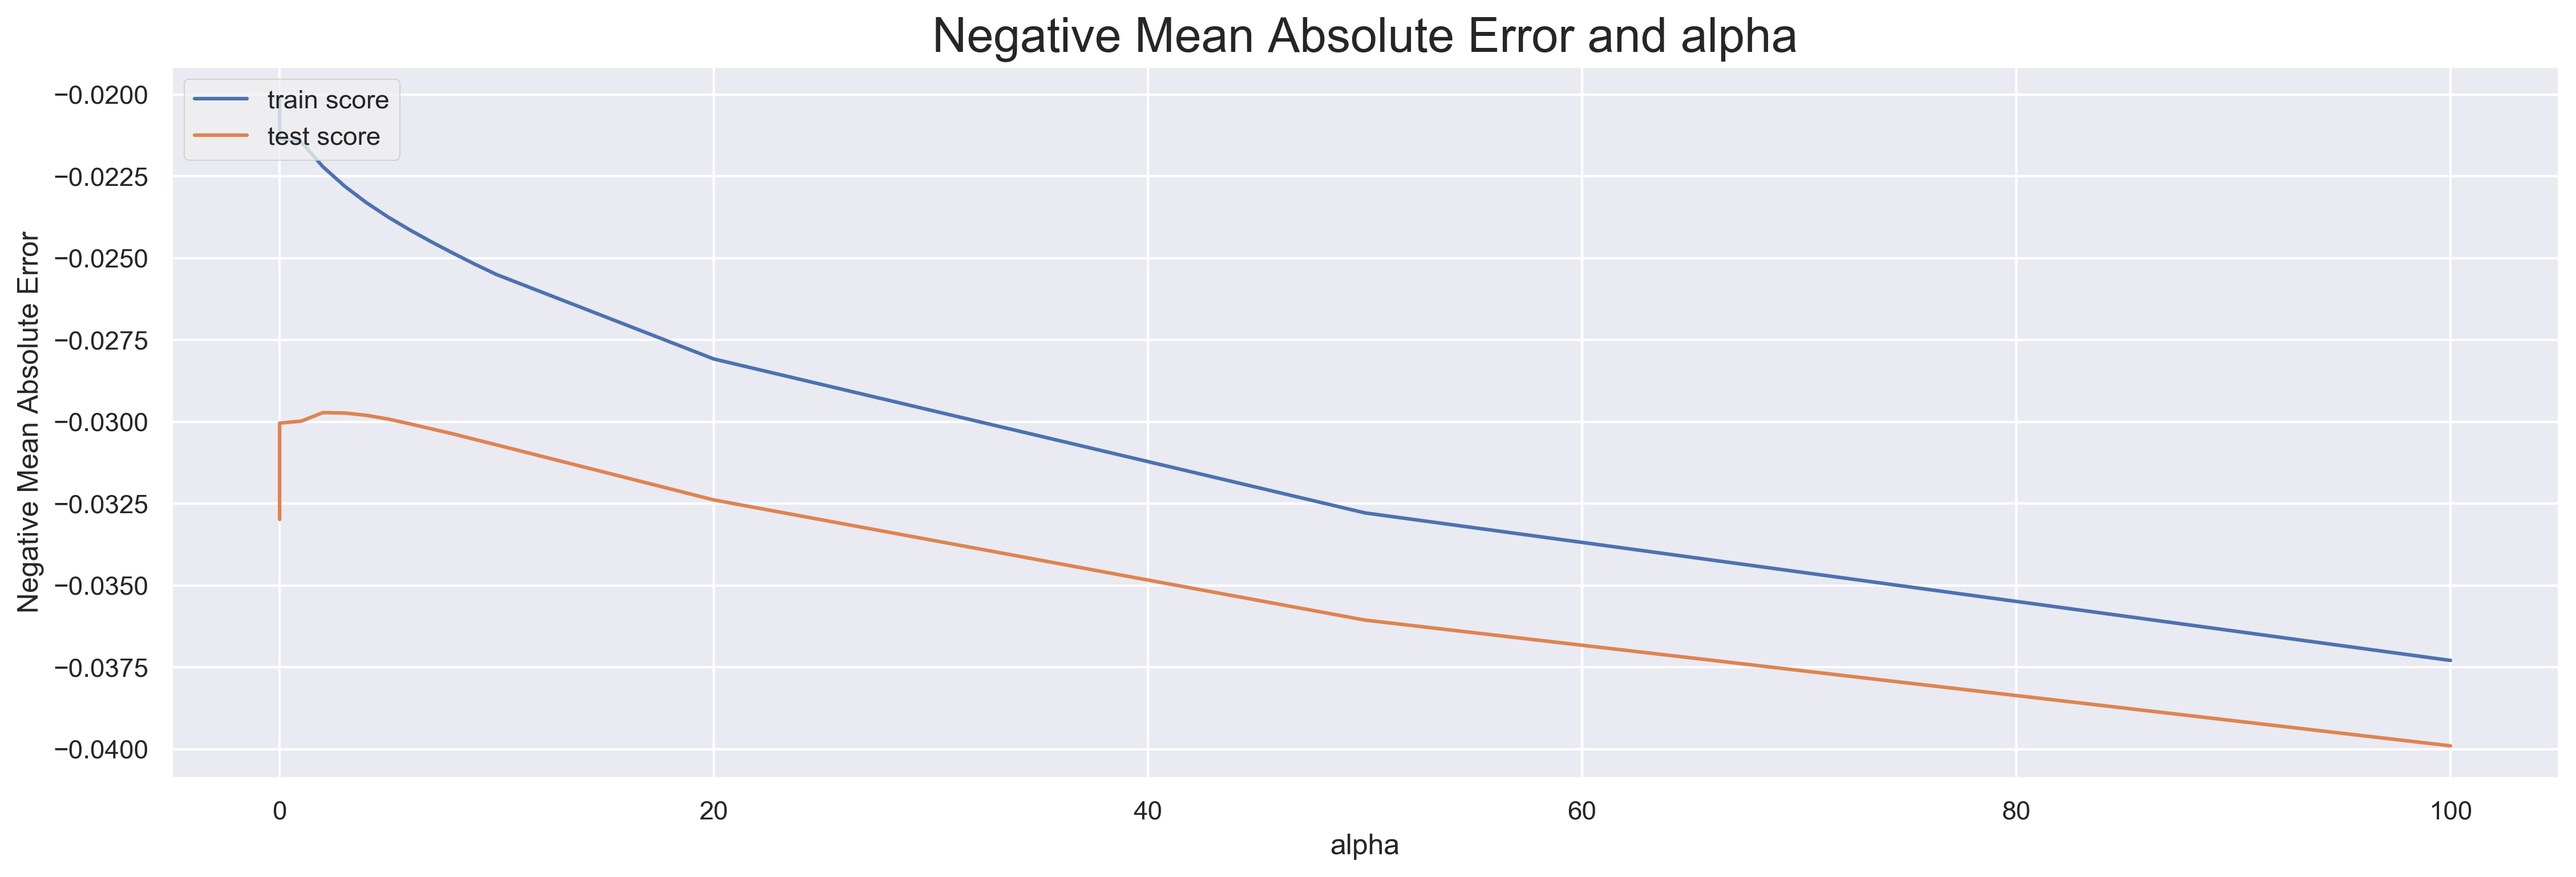

In [65]:
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')
# plotting
plt.figure(figsize=default_figsize, dpi=300)
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.tight_layout()
plt.style.use('fivethirtyeight')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [66]:
def fit_and_predict_regression(regressor):
    regressor.fit(X_train, y_train)
    y_train_pred = regressor.predict(X_train)
    print(r2_score(y_true=y_train, y_pred=y_train_pred))
    y_test = housing_model_test['NormalSalePrice']
    X_test = housing_model_test[housing_model_test.columns[~housing_model_test.columns.isin(['NormalSalePrice'])]]
    y_test_pred = regressor.predict(X_test)
    print(r2_score(y_true=y_test, y_pred=y_test_pred))

In [67]:
ridge_alpha = model_cv.best_params_['alpha']
print('alpha: ', ridge_alpha)

ridge = Ridge(alpha=ridge_alpha)
fit_and_predict_regression(ridge)

alpha:  2.0
0.9505192075481103
0.8919358042045753


## Lasso 

In [68]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator=lasso,
                        param_grid=params,
                        scoring='neg_mean_absolute_error',
                        cv=folds,
                        return_train_score=True,
                        verbose=1)

model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [69]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0         0.0189        0.0014           0.0009          0.0000      0.0001   
1         0.0089        0.0020           0.0008          0.0001      0.0010   
2         0.0031        0.0000           0.0007          0.0000      0.0100   
3         0.0027        0.0003           0.0009          0.0001      0.0500   
4         0.0026        0.0002           0.0008          0.0000      0.1000   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}            -0.0298            -0.0288            -0.0297   
1   {'alpha': 0.001}            -0.0337            -0.0337            -0.0373   
2    {'alpha': 0.01}            -0.0666            -0.0604            -0.0703   
3    {'alpha': 0.05}            -0.1107            -0.1093            -0.1150   
4     {'alpha': 0.1}            -0.1107            -0.1093            -0.1150   

   split3_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
0            -0.0268  ...          -0.0288          0.0011                1   
1            -0.0304  ...          -0.0345          0.0026                2   
2            -0.0592  ...          -0.0643          0.0041                3   
3            -0.1017  ...          -0.1082          0.0047                4   
4            -0.1017  ...          -0.1082          0.0047                4   

   split0_train_score  split1_train_score  split2_train_score  \
0             -0.0223             -0.0228             -0.0221   
1             -0.0310             -0.0312             -0.0311   
2             -0.0623             -0.0647             -0.0626   
3             -0.1075             -0.1079             -0.1064   
4             -0.1075             -0.1079             -0.1064   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
0             -0.0230             -0.0232           -0.0227           0.0004  
1             -0.0314             -0.0316           -0.0312           0.0002  
2             -0.0640             -0.0616           -0.0630           0.0011  
3             -0.1097             -0.1092           -0.1081           0.0012  
4             -0.1097             -0.1092           -0.1081           0.0012  

[5 rows x 21 columns]

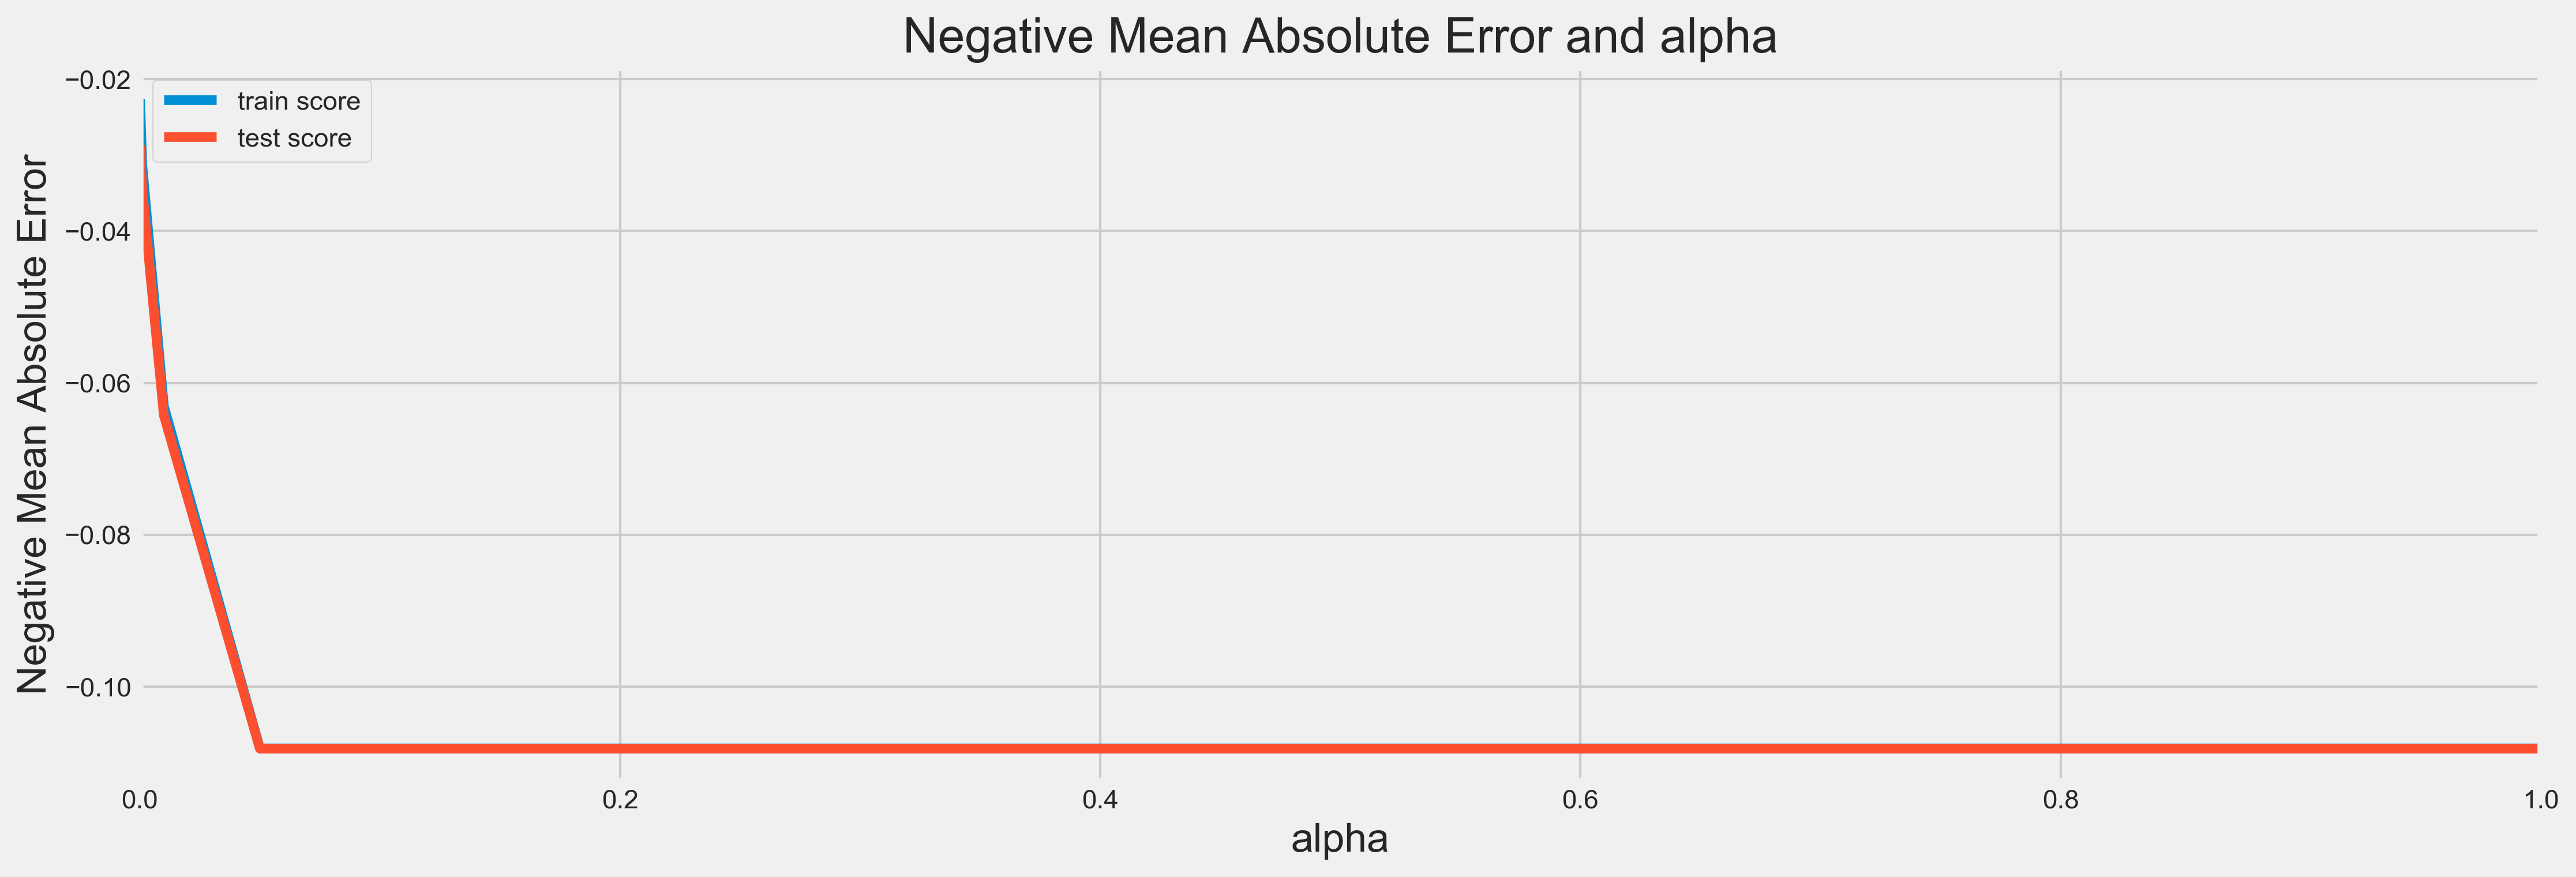

In [70]:
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.figure(figsize=default_figsize, dpi=300)
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'], )
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.tight_layout()
plt.style.use('fivethirtyeight')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
axes = plt.gca()
axes.set_xlim([0,1])
plt.show()

In [71]:
lasso_alpha = model_cv.best_params_['alpha']
print('alpha: ',lasso_alpha)

lasso = Lasso(alpha=lasso_alpha)
fit_and_predict_regression(lasso)

alpha:  0.0001
0.946583300823495
0.8931495750462322


In [72]:
def variables_with_coefficent(regressor):
    list_of_tuples = list(zip(X_train.columns, regressor.coef_))
    df_coef = pd.DataFrame(list_of_tuples, columns=['Variable', 'Coef'])
    df_coef = df_coef[df_coef['Coef'] != 0]
    df_coef = df_coef.sort_values(by='Coef', ascending=False).reset_index()
    return df_coef

In [73]:
df_coef = variables_with_coefficent(lasso)
df_coef.shape

(145, 3)

#### We can see that Lasso regression has eliminated variables from **251** to **145**. 

# Result

## R2 Score

### Ridge

|   |   |
|---|---|
|  Training | Testing   |
|0.9505192075481103| 0.8919358042045753|


### Lasso

|   |   |
|---|---|
|  Training | Testing   |
|0.946583300823495| 0.8931495750462322|


## Alpha/Lambda

### Ridge 

In [74]:
print("Ridge Alpha/Lambda: ", ridge_alpha)

Ridge Alpha/Lambda:  2.0


### Lasso

In [75]:
print("Lasso Alpha/Lambda: ", lasso_alpha)

Lasso Alpha/Lambda:  0.0001


When we started with the regression we had 251 variables which is quite a large number of variables. I will be selecting Lasso regression to select significant variables as it has removed the less significant variables. Also, the **r2_score** of the both the regression is almost same.

## Top variables

In [76]:
df_coef.head(5)

index        Variable   Coef
0      8       GrLivArea 0.2830
1      5     TotalBsmtSF 0.1094
2     91   OverallQual_9 0.0626
3     28     MSZoning_RH 0.0546
4     92  OverallQual_10 0.0482

### Top 5 variables (in order of importance) after the regression are

1. #### GrLivArea: Above grade (ground) living area square feet

This makes sense as one of the important predictor for the property price, the bigger the living area, the costlier the property

2. #### TotalBsmtSF: Total square feet of basement area

Basement area also corresponds to overall area of the property thus an important variable for price prediction

3. #### OverallQual_9: Rates the overall material and finish of the house

The overall qualtity of the property is also an important predictor of the price. The properties with rating 9 plays an important role in the property cost.

4. #### MSZoning_RH: Identifies the general zoning classification of the sale.

Property in the zone classified as *Residential High Density* also dictates the price of the property.

5. #### OverallQual_10: Rates the overall material and finish of the house

The overall qualtity of the property is also an important predictor of the price. The properties with rating 10 plays an important role in the property cost.


# Code related to subjective questions

## Question 1

In [77]:
# Doubling the alpha for Ridge
ridge = Ridge(alpha=2 * ridge_alpha)
fit_and_predict_regression(ridge)

0.9458876448967827
0.8933899762780211


In [78]:
# Doubling the alpha for Lasso
lasso = Lasso(alpha=2 * lasso_alpha)
fit_and_predict_regression(lasso)

0.9386239514600085
0.8942786744641913


In [79]:
df_coef = variables_with_coefficent(lasso)
df_coef.shape

(116, 3)

In [80]:
df_coef.head(5)

index       Variable   Coef
0      8      GrLivArea 0.2746
1      5    TotalBsmtSF 0.1191
2     91  OverallQual_9 0.0592
3      9     GarageArea 0.0499
4    100  OverallCond_9 0.0407

## Question 3

In [81]:
# Updating X_train and X_test to remove the previous significant variables
X_train = housing_model_train.drop([
    'GrLivArea', 'TotalBsmtSF', 'OverallQual_9', 'MSZoning_RH',
    'OverallQual_10'
],
                                   axis=1)

housing_model_test = housing_model_test.drop([
    'GrLivArea', 'TotalBsmtSF', 'OverallQual_9', 'MSZoning_RH',
    'OverallQual_10'
],
                                 axis=1)

In [82]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator=lasso,
                        param_grid=params,
                        scoring='neg_mean_absolute_error',
                        cv=folds,
                        return_train_score=True,
                        verbose=1)

model_cv.fit(X_train, y_train)

lasso_alpha = model_cv.best_params_['alpha']
print('alpha: ',lasso_alpha)

lasso = Lasso(alpha=lasso_alpha)
fit_and_predict_regression(lasso)
df_coef = variables_with_coefficent(lasso)
df_coef.shape

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


alpha:  0.0001
0.9424654547527702
0.8932079018443114


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.7s finished


(148, 3)

In [83]:
### Top variables after the change
df_coef.head(5)

index       Variable   Coef
0      5       1stFlrSF 0.2317
1      6       2ndFlrSF 0.1482
2      3     BsmtFinSF1 0.0670
3      1        LotArea 0.0496
4     95  OverallCond_9 0.0453